In [1]:
# DASK client set

import os
import sys
from dask.distributed import Client
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json', threads_per_worker=2, n_workers=6)
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json')
client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler_10.json')  

# add private module path for workers
# client.run(lambda: os.environ.update({'PYTHONPATH': '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2'}))
# def add_path():
#     if '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2' not in sys.path:
#         sys.path.append('/proj/kimyy/Dropbox/source/python/all/Modules/CESM2')

# client.run(add_path)

def setup_module_path():
    module_path = '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2'
    if module_path not in sys.path:
        sys.path.append(module_path)

client.run(setup_module_path)

client

# get path for path changes in Jupyter notebook: File - Open from Path - insert relative_path
notebook_path = os.path.abspath(".")
_, _, relative_path = notebook_path.partition('/all/')
relative_path = '/all/' + relative_path
relative_path

'/all/Model/CESM2/Earth_System_Predictability/ASSM/Aleph'

# Load modules

In [2]:
# load public modules

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import matplotlib.ticker as mticker
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
from scipy.interpolate import griddata
import cmocean
from cmcrameri import cm
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd
import cftime
import pop_tools
from pprint import pprint
import time
import subprocess
import re as re_mod
import cftime
import datetime
from scipy.stats import ttest_1samp

In [3]:
# load private modules

import sys
sys.path.append('/proj/kimyy/Dropbox/source/python/all/Modules/CESM2')
from KYY_CESM2_preprocessing import CESM2_config
# import KYY_CESM2_preprocessing
# import importlib
# importlib.reload(KYY_CESM2_preprocessing)

# Variable configuration

In [5]:
# 1. NPP (Total)
cfg_var_NPP_TOT=CESM2_config()
cfg_var_NPP_TOT.year_s=1960
cfg_var_NPP_TOT.year_e=2020
cfg_var_NPP_TOT.setvar('photoC_TOT_zint_100m')

# 2. NPP (Diat)
cfg_var_NPP_diat=CESM2_config()
cfg_var_NPP_diat.year_s=1960
cfg_var_NPP_diat.year_e=2020
cfg_var_NPP_diat.setvar('photoC_diat_zint_100m')

# 3. NPP (Small Pytho.)
cfg_var_NPP_sp=CESM2_config()
cfg_var_NPP_sp.year_s=1960
cfg_var_NPP_sp.year_e=2020
cfg_var_NPP_sp.setvar('photoC_sp_zint_100m')

# 4. NPP (diaz.)
cfg_var_NPP_diaz=CESM2_config()
cfg_var_NPP_diaz.year_s=1960
cfg_var_NPP_diaz.year_e=2020
cfg_var_NPP_diaz.setvar('photoC_diaz_zint_100m')

if cfg_var_NPP_TOT.comp=='ocn':
    ds_grid = pop_tools.get_grid('POP_gx1v7')

# Read dataset

In [8]:
# define preprocessing function

exceptcv=['time','lon','lat','lev', 'TLONG', 'TLAT', 'z_w', 
          cfg_var_NPP_TOT.var, cfg_var_NPP_diat.var, cfg_var_NPP_sp.var, cfg_var_NPP_diaz.var]
def process_coords(ds, sd, ed, drop=True, except_coord_vars=exceptcv):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]
    
    if drop:
        ds= ds.drop(coord_vars)
        ds= ds.sel(time=slice(sd, ed))
        return ds
    else:
        return ds.set_coords(coord_vars)


start_date = cftime.DatetimeNoLeap(cfg_var_NPP_TOT.year_s, 2, 1)
end_date = cftime.DatetimeNoLeap(cfg_var_NPP_TOT.year_e+1, 1, 1)

exceptcv2=['time','lon','lat','lev', 'TLONG', 'TLAT', 
          cfg_var_NPP_TOT.var, cfg_var_NPP_diat.var, cfg_var_NPP_sp.var, cfg_var_NPP_diaz.var]
def process_coords_hcst(ds, drop=True, except_coord_vars=exceptcv2):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]
    
    if drop:
        ds= ds.drop(coord_vars)
        return ds
    else:
        return ds.set_coords(coord_vars)

In [11]:
# Read ODA dataset (all)

start_time = time.time()


# 1. NPP_TOT
cfg_var_NPP_TOT.ODA_path_load(cfg_var_NPP_TOT.var)

ODA_ds = xr.open_mfdataset(cfg_var_NPP_TOT.ODA_file_list[0][0:10],
                           chunks={'time': 12}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var_NPP_TOT.ODA_ensembles[0:10]], 'time'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords(ds, start_date, end_date),
                           decode_cf=True, 
                           decode_times=True)

ODA_ds2 = xr.open_mfdataset(cfg_var_NPP_TOT.ODA_file_list[0][10:20], 
                           chunks={'time': 12}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var_NPP_TOT.ODA_ensembles[10:20]], 'time'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords(ds, start_date, end_date),
                           decode_cf=True, 
                           decode_times=True)

# en4.2 -> until 2021; projdv7.3 -> until 2020; need to be read separately
ODA_ds_a = []
ODA_ds_a.append(ODA_ds)
ODA_ds_xr = xr.concat(ODA_ds_a, dim='time')
ODA_ds_xr = ODA_ds_xr.expand_dims({'ens': range(10)})

ODA_ds2_a = []
ODA_ds2_a.append(ODA_ds2)
ODA_ds2_xr = xr.concat(ODA_ds2_a, dim='time')
ODA_ds2_xr = ODA_ds2_xr.expand_dims({'ens': range(10, 20)})

cfg_var_NPP_TOT.ODA_ds = []
cfg_var_NPP_TOT.ODA_ds.append(ODA_ds_xr)
cfg_var_NPP_TOT.ODA_ds.append(ODA_ds2_xr)
cfg_var_NPP_TOT.ODA_ds = xr.concat(cfg_var_NPP_TOT.ODA_ds, dim='ens')
cfg_var_NPP_TOT.ODA_ds = cfg_var_NPP_TOT.ODA_ds.reindex(ens=list(range(1, 20+1)))
cfg_var_NPP_TOT.ODA_ds = cfg_var_NPP_TOT.ODA_ds.sortby('time')

cfg_var_NPP_TOT.ODA_ds = cfg_var_NPP_TOT.ODA_ds.rename({"concat_dim": "ens_ODA"})
new_time = cfg_var_NPP_TOT.ODA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_NPP_TOT.ODA_ds.time))
cfg_var_NPP_TOT.ODA_ds = cfg_var_NPP_TOT.ODA_ds.assign_coords(time=new_time)
cfg_var_NPP_TOT.ODA_ds = cfg_var_NPP_TOT.ODA_ds.drop('ens')
cfg_var_NPP_TOT.ODA_ds=cfg_var_NPP_TOT.ODA_ds.mean(dim='ens')



# 2. NPP_diat
cfg_var_NPP_diat.ODA_path_load(cfg_var_NPP_diat.var)

ODA_ds = xr.open_mfdataset(cfg_var_NPP_diat.ODA_file_list[0][0:10],
                           chunks={'time': 12}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var_NPP_diat.ODA_ensembles[0:10]], 'time'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords(ds, start_date, end_date),
                           decode_cf=True, 
                           decode_times=True)

ODA_ds2 = xr.open_mfdataset(cfg_var_NPP_diat.ODA_file_list[0][10:20], 
                           chunks={'time': 12}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var_NPP_diat.ODA_ensembles[10:20]], 'time'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords(ds, start_date, end_date),
                           decode_cf=True, 
                           decode_times=True)

# en4.2 -> until 2021; projdv7.3 -> until 2020; need to be read separately
ODA_ds_a = []
ODA_ds_a.append(ODA_ds)
ODA_ds_xr = xr.concat(ODA_ds_a, dim='time')
ODA_ds_xr = ODA_ds_xr.expand_dims({'ens': range(10)})

ODA_ds2_a = []
ODA_ds2_a.append(ODA_ds2)
ODA_ds2_xr = xr.concat(ODA_ds2_a, dim='time')
ODA_ds2_xr = ODA_ds2_xr.expand_dims({'ens': range(10, 20)})

cfg_var_NPP_diat.ODA_ds = []
cfg_var_NPP_diat.ODA_ds.append(ODA_ds_xr)
cfg_var_NPP_diat.ODA_ds.append(ODA_ds2_xr)
cfg_var_NPP_diat.ODA_ds = xr.concat(cfg_var_NPP_diat.ODA_ds, dim='ens')
cfg_var_NPP_diat.ODA_ds = cfg_var_NPP_diat.ODA_ds.reindex(ens=list(range(1, 20+1)))
cfg_var_NPP_diat.ODA_ds = cfg_var_NPP_diat.ODA_ds.sortby('time')

cfg_var_NPP_diat.ODA_ds = cfg_var_NPP_diat.ODA_ds.rename({"concat_dim": "ens_ODA"})
new_time = cfg_var_NPP_diat.ODA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_NPP_diat.ODA_ds.time))
cfg_var_NPP_diat.ODA_ds = cfg_var_NPP_diat.ODA_ds.assign_coords(time=new_time)
cfg_var_NPP_diat.ODA_ds = cfg_var_NPP_diat.ODA_ds.drop('ens')
cfg_var_NPP_diat.ODA_ds=cfg_var_NPP_diat.ODA_ds.mean(dim='ens')




# 3. NPP_sp
cfg_var_NPP_sp.ODA_path_load(cfg_var_NPP_sp.var)

ODA_ds = xr.open_mfdataset(cfg_var_NPP_sp.ODA_file_list[0][0:10],
                           chunks={'time': 12}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var_NPP_sp.ODA_ensembles[0:10]], 'time'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords(ds, start_date, end_date),
                           decode_cf=True, 
                           decode_times=True)

ODA_ds2 = xr.open_mfdataset(cfg_var_NPP_sp.ODA_file_list[0][10:20], 
                           chunks={'time': 12}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var_NPP_sp.ODA_ensembles[10:20]], 'time'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords(ds, start_date, end_date),
                           decode_cf=True, 
                           decode_times=True)

# en4.2 -> until 2021; projdv7.3 -> until 2020; need to be read separately
ODA_ds_a = []
ODA_ds_a.append(ODA_ds)
ODA_ds_xr = xr.concat(ODA_ds_a, dim='time')
ODA_ds_xr = ODA_ds_xr.expand_dims({'ens': range(10)})

ODA_ds2_a = []
ODA_ds2_a.append(ODA_ds2)
ODA_ds2_xr = xr.concat(ODA_ds2_a, dim='time')
ODA_ds2_xr = ODA_ds2_xr.expand_dims({'ens': range(10, 20)})

cfg_var_NPP_sp.ODA_ds = []
cfg_var_NPP_sp.ODA_ds.append(ODA_ds_xr)
cfg_var_NPP_sp.ODA_ds.append(ODA_ds2_xr)
cfg_var_NPP_sp.ODA_ds = xr.concat(cfg_var_NPP_sp.ODA_ds, dim='ens')
cfg_var_NPP_sp.ODA_ds = cfg_var_NPP_sp.ODA_ds.reindex(ens=list(range(1, 20+1)))
cfg_var_NPP_sp.ODA_ds = cfg_var_NPP_sp.ODA_ds.sortby('time')

cfg_var_NPP_sp.ODA_ds = cfg_var_NPP_sp.ODA_ds.rename({"concat_dim": "ens_ODA"})
new_time = cfg_var_NPP_sp.ODA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_NPP_sp.ODA_ds.time))
cfg_var_NPP_sp.ODA_ds = cfg_var_NPP_sp.ODA_ds.assign_coords(time=new_time)
cfg_var_NPP_sp.ODA_ds = cfg_var_NPP_sp.ODA_ds.drop('ens')
cfg_var_NPP_sp.ODA_ds=cfg_var_NPP_sp.ODA_ds.mean(dim='ens')




# 4. NPP_diaz
cfg_var_NPP_diaz.ODA_path_load(cfg_var_NPP_diaz.var)

ODA_ds = xr.open_mfdataset(cfg_var_NPP_diaz.ODA_file_list[0][0:10],
                           chunks={'time': 12}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var_NPP_diaz.ODA_ensembles[0:10]], 'time'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords(ds, start_date, end_date),
                           decode_cf=True, 
                           decode_times=True)

ODA_ds2 = xr.open_mfdataset(cfg_var_NPP_diaz.ODA_file_list[0][10:20], 
                           chunks={'time': 12}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var_NPP_diaz.ODA_ensembles[10:20]], 'time'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords(ds, start_date, end_date),
                           decode_cf=True, 
                           decode_times=True)

# en4.2 -> until 2021; projdv7.3 -> until 2020; need to be read separately
ODA_ds_a = []
ODA_ds_a.append(ODA_ds)
ODA_ds_xr = xr.concat(ODA_ds_a, dim='time')
ODA_ds_xr = ODA_ds_xr.expand_dims({'ens': range(10)})

ODA_ds2_a = []
ODA_ds2_a.append(ODA_ds2)
ODA_ds2_xr = xr.concat(ODA_ds2_a, dim='time')
ODA_ds2_xr = ODA_ds2_xr.expand_dims({'ens': range(10, 20)})

cfg_var_NPP_diaz.ODA_ds = []
cfg_var_NPP_diaz.ODA_ds.append(ODA_ds_xr)
cfg_var_NPP_diaz.ODA_ds.append(ODA_ds2_xr)
cfg_var_NPP_diaz.ODA_ds = xr.concat(cfg_var_NPP_diaz.ODA_ds, dim='ens')
cfg_var_NPP_diaz.ODA_ds = cfg_var_NPP_diaz.ODA_ds.reindex(ens=list(range(1, 20+1)))
cfg_var_NPP_diaz.ODA_ds = cfg_var_NPP_diaz.ODA_ds.sortby('time')

cfg_var_NPP_diaz.ODA_ds = cfg_var_NPP_diaz.ODA_ds.rename({"concat_dim": "ens_ODA"})
new_time = cfg_var_NPP_diaz.ODA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_NPP_diaz.ODA_ds.time))
cfg_var_NPP_diaz.ODA_ds = cfg_var_NPP_diaz.ODA_ds.assign_coords(time=new_time)
cfg_var_NPP_diaz.ODA_ds = cfg_var_NPP_diaz.ODA_ds.drop('ens')
cfg_var_NPP_diaz.ODA_ds=cfg_var_NPP_diaz.ODA_ds.mean(dim='ens')


end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ODA: ' + str(elapsed_time))

elasped time for reading ODA: 325.773152589798


# Take mean & std

In [49]:
start_time = time.time()


# Step 5: 연도별로 그룹화하고 NaN을 무시한 연평균 계산 .mean(dim='ens_ODA')
timmean_NPP_TOT = cfg_var_NPP_TOT.ODA_ds.mean(dim='time', skipna=True).mean(dim='ens_ODA').compute()
timstd_NPP_TOT = cfg_var_NPP_TOT.ODA_ds.std(dim='time', skipna=True).mean(dim='ens_ODA').compute()

timmean_NPP_diat = cfg_var_NPP_diat.ODA_ds.mean(dim='time', skipna=True).mean(dim='ens_ODA').compute()
timmean_NPP_diat['ratio'] = timmean_NPP_diat[cfg_var_NPP_diat.var] / timmean_NPP_TOT[cfg_var_NPP_TOT.var]
timstd_NPP_diat = cfg_var_NPP_diat.ODA_ds.std(dim='time', skipna=True).mean(dim='ens_ODA').compute()
timstd_NPP_diat['ratio'] = timstd_NPP_diat[cfg_var_NPP_diat.var] / timstd_NPP_TOT[cfg_var_NPP_TOT.var]

timmean_NPP_sp = cfg_var_NPP_sp.ODA_ds.mean(dim='time', skipna=True).mean(dim='ens_ODA').compute()
timmean_NPP_sp['ratio'] = timmean_NPP_sp[cfg_var_NPP_sp.var] / timmean_NPP_TOT[cfg_var_NPP_TOT.var]
timstd_NPP_sp = cfg_var_NPP_sp.ODA_ds.std(dim='time', skipna=True).mean(dim='ens_ODA').compute()
timstd_NPP_sp['ratio'] = timstd_NPP_sp[cfg_var_NPP_sp.var] / timstd_NPP_TOT[cfg_var_NPP_TOT.var]

timmean_NPP_diaz = cfg_var_NPP_diaz.ODA_ds.mean(dim='time', skipna=True).mean(dim='ens_ODA').compute()
timmean_NPP_diaz['ratio'] = timmean_NPP_diaz[cfg_var_NPP_diaz.var] / timmean_NPP_TOT[cfg_var_NPP_TOT.var]
timstd_NPP_diaz = cfg_var_NPP_diaz.ODA_ds.std(dim='time', skipna=True).mean(dim='ens_ODA').compute()
timstd_NPP_diaz['ratio'] = timstd_NPP_diaz[cfg_var_NPP_diaz.var] / timstd_NPP_TOT[cfg_var_NPP_TOT.var]

# ref_time=cfg_var.ODA_ds.time.groupby('time.year').mean(dim='time')

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ODA: ' + str(elapsed_time))

elasped time for reading ODA: 629.9968936443329


In [21]:
# take ensemble mean
# oda_annual_mean['enm']=oda_annual_mean[cfg_var.var].mean(dim='ens_ODA')


In [38]:
timmean_ratio_diat

<xarray.DataArray (ens_ODA: 20, nlat: 384, nlon: 320)>
dask.array<truediv, shape=(20, 384, 320), dtype=float32, chunksize=(2, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * ens_ODA                (ens_ODA) int64 0 1 2 3 4 5 6 ... 14 15 16 17 18 19
    TLONG                  (nlat, nlon) float64 320.6 321.7 ... 319.4 319.8
    TLAT                   (nlat, nlon) float64 -79.22 -79.22 ... 72.19 72.19
    photoC_diat_zint_100m  (ens_ODA, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon

In [20]:
# define pop funtion for figure

def pop_add_cyclic(da):
        #copied from Mattew Longs github (https://gist.github.com/matt-long/50433da346da8ac17cde926eec90a87c) and modified for DA
        #This doesn't work with Dask (DA should be loaded)
        #Input DA must have the name and coords (TLONG and TLAT), and don't have other dims (time etc.)
        #Output is DA
        nj = da.TLAT.shape[0]
        ni = da.TLONG.shape[1]
        xL = int(ni/2 - 1)
        xR = int(xL + ni)
        tlon = da.TLONG.data
        tlat = da.TLAT.data
        tlon = np.where(np.greater_equal(tlon, min(tlon[:,0])), tlon-360., tlon)
        lon  = np.concatenate((tlon, tlon + 360.), 1)
        lon = lon[:, xL:xR]
        if ni == 320:
            lon[367:-3, 0] = lon[367:-3, 0] + 360.
        lon = lon - 360.
        lon = np.hstack((lon, lon[:, 0:1] + 360.))
        if ni == 320:
            lon[367:, -1] = lon[367:, -1] - 360.
        #-- trick cartopy into doing the right thing:
        #   it gets confused when the cyclic coords are identical
        lon[:, 0] = lon[:, 0] - 1e-8
        #-- periodicity
        lat = np.concatenate((tlat, tlat), 1)
        lat = lat[:, xL:xR]
        lat = np.hstack((lat, lat[:,0:1]))
        TLAT = xr.DataArray(lat, dims=('nlat', 'nlon'))
        TLONG = xr.DataArray(lon, dims=('nlat', 'nlon'))
        # copy vars
        v = da.name
        v_dims = da.dims
        # determine and sort other dimensions
        other_dims = set(v_dims) - {'nlat', 'nlon'}
        other_dims = tuple([d for d in v_dims if d in other_dims])
        lon_dim = da.dims.index('nlon')
        field = da.data
        field = np.concatenate((field, field), lon_dim)
        field = field[:, xL:xR]
        field = np.concatenate((field, field[:, 0:1]), lon_dim)
        dao = xr.DataArray(field, dims=other_dims+('nlat', 'nlon'), attrs=da.attrs)
        dao = dao.assign_coords(TLONG=TLONG)
        dao = dao.assign_coords(TLAT=TLAT)
        return dao

In [34]:
timmean_NPP_diat

<xarray.Dataset>
Dimensions:                (z_w: 60, ens_ODA: 20, nlat: 384, nlon: 320)
Coordinates:
  * z_w                    (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * ens_ODA                (ens_ODA) int64 0 1 2 3 4 5 6 ... 14 15 16 17 18 19
    TLONG                  (nlat, nlon) float64 320.6 321.7 ... 319.4 319.8
    TLAT                   (nlat, nlon) float64 -79.22 -79.22 ... 72.19 72.19
Dimensions without coordinates: nlat, nlon
Data variables:
    photoC_diat_zint_100m  (ens_ODA, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>

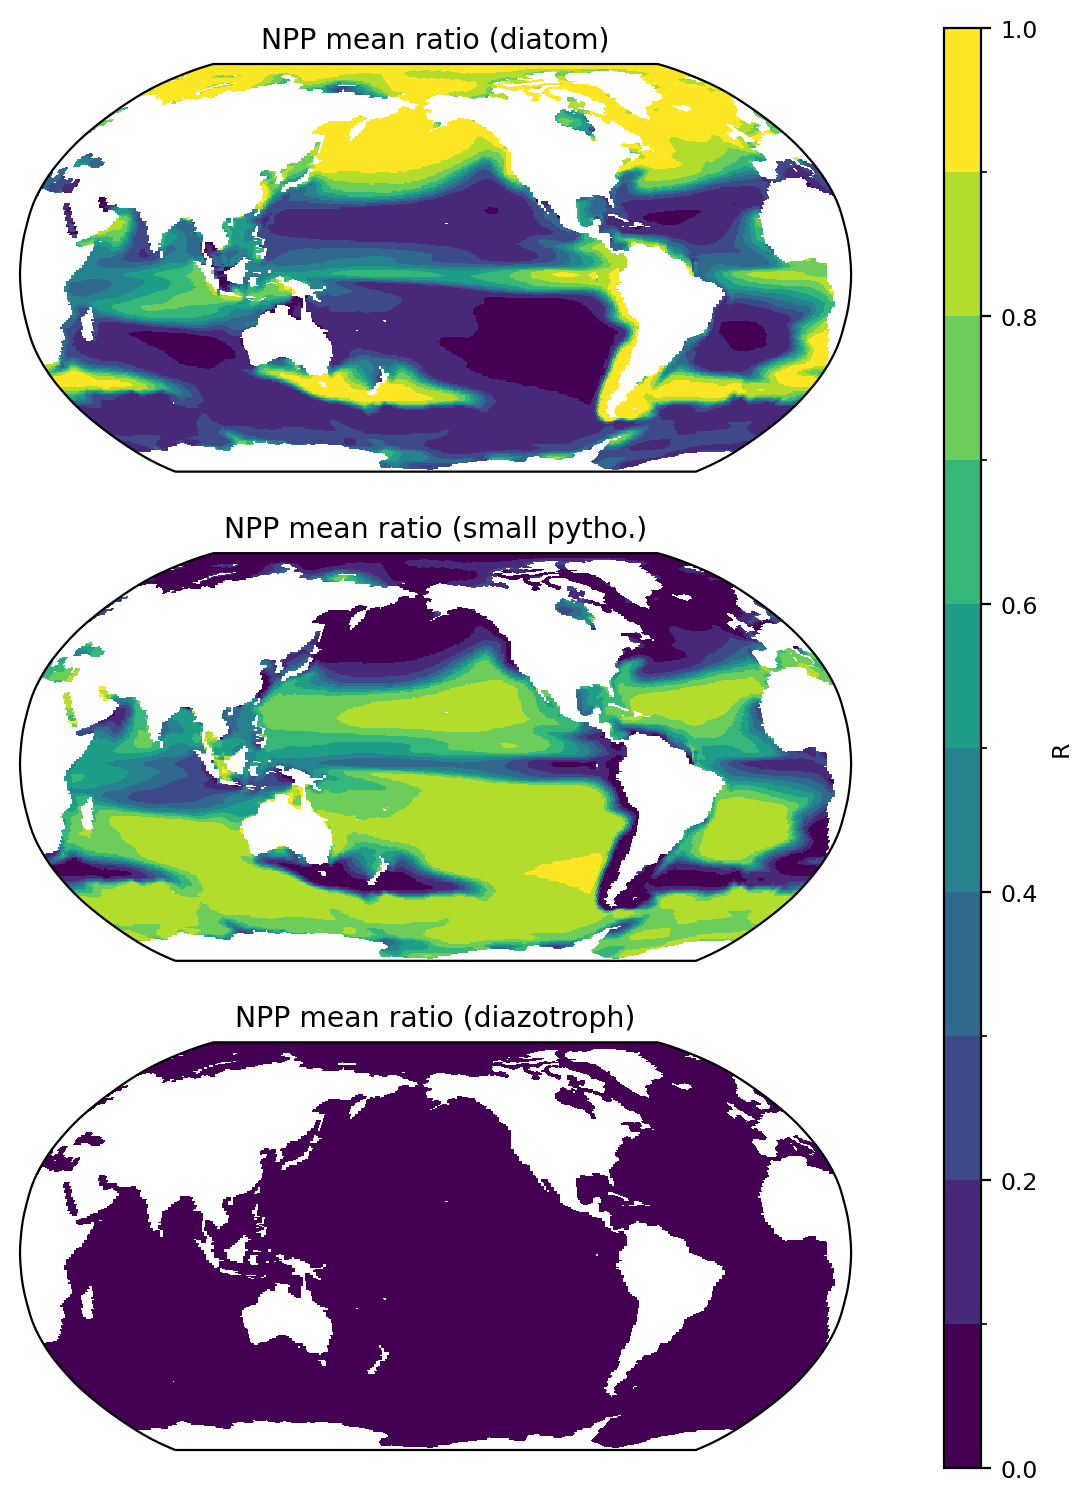

elasped time for calculating correlation: 10.674354791641235


In [70]:
# plot for NPP_ratio

start_time = time.time()

varn=cfg_var_NPP_TOT.var #example

if cfg_var_NPP_TOT.comp=='ocn':
    ds_grid = pop_tools.get_grid('POP_gx1v7')

data_array=timmean_NPP_diat['ratio']
data_array.attrs['name'] = cfg_var_NPP_TOT.var
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT

cmap = plt.cm.viridis  
levels = np.linspace(0, 1, 11)  
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N, clip=True)
projection = ccrs.Robinson(central_longitude=200)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(18.5, 9), 
             dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection}, constrained_layout=False)


# fig1: diat
plt1=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[0], 
                        transform=ccrs.PlateCarree(), vmax=1, vmin=0,cmap=cmap, norm=norm, add_colorbar=False)

axes[0].set_title('NPP mean ratio (diatom)')
# axes[0].gridlines(draw_labels=True) 
# axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}°'))
# axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}°'))


# fig2: sp
data_array=timmean_NPP_sp['ratio']
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT

plt2=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[1], 
                        transform=ccrs.PlateCarree(), vmax=1, vmin=0,cmap=cmap, norm=norm, add_colorbar=False)
axes[1].set_title('NPP mean ratio (small pytho.)')

# fig2: diaz
data_array=timmean_NPP_diaz['ratio']
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT

plt3=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[2], 
                        transform=ccrs.PlateCarree(), vmax=1, vmin=0,cmap=cmap, norm=norm, add_colorbar=False)
axes[2].set_title('NPP mean ratio (diazotroph)')

plt.rcParams.update({'font.size': 8.5})

cbar_a_c = fig.add_axes([0.65, 0.1, 0.01, 0.8])  # [left, bottom, width, height] 비율로 컬러바 위치와 크기 설정
cbar1 = fig.colorbar(plt1, cax=cbar_a_c, orientation='vertical')
cbar1.set_label('R')

plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for calculating correlation: ' + str(elapsed_time))

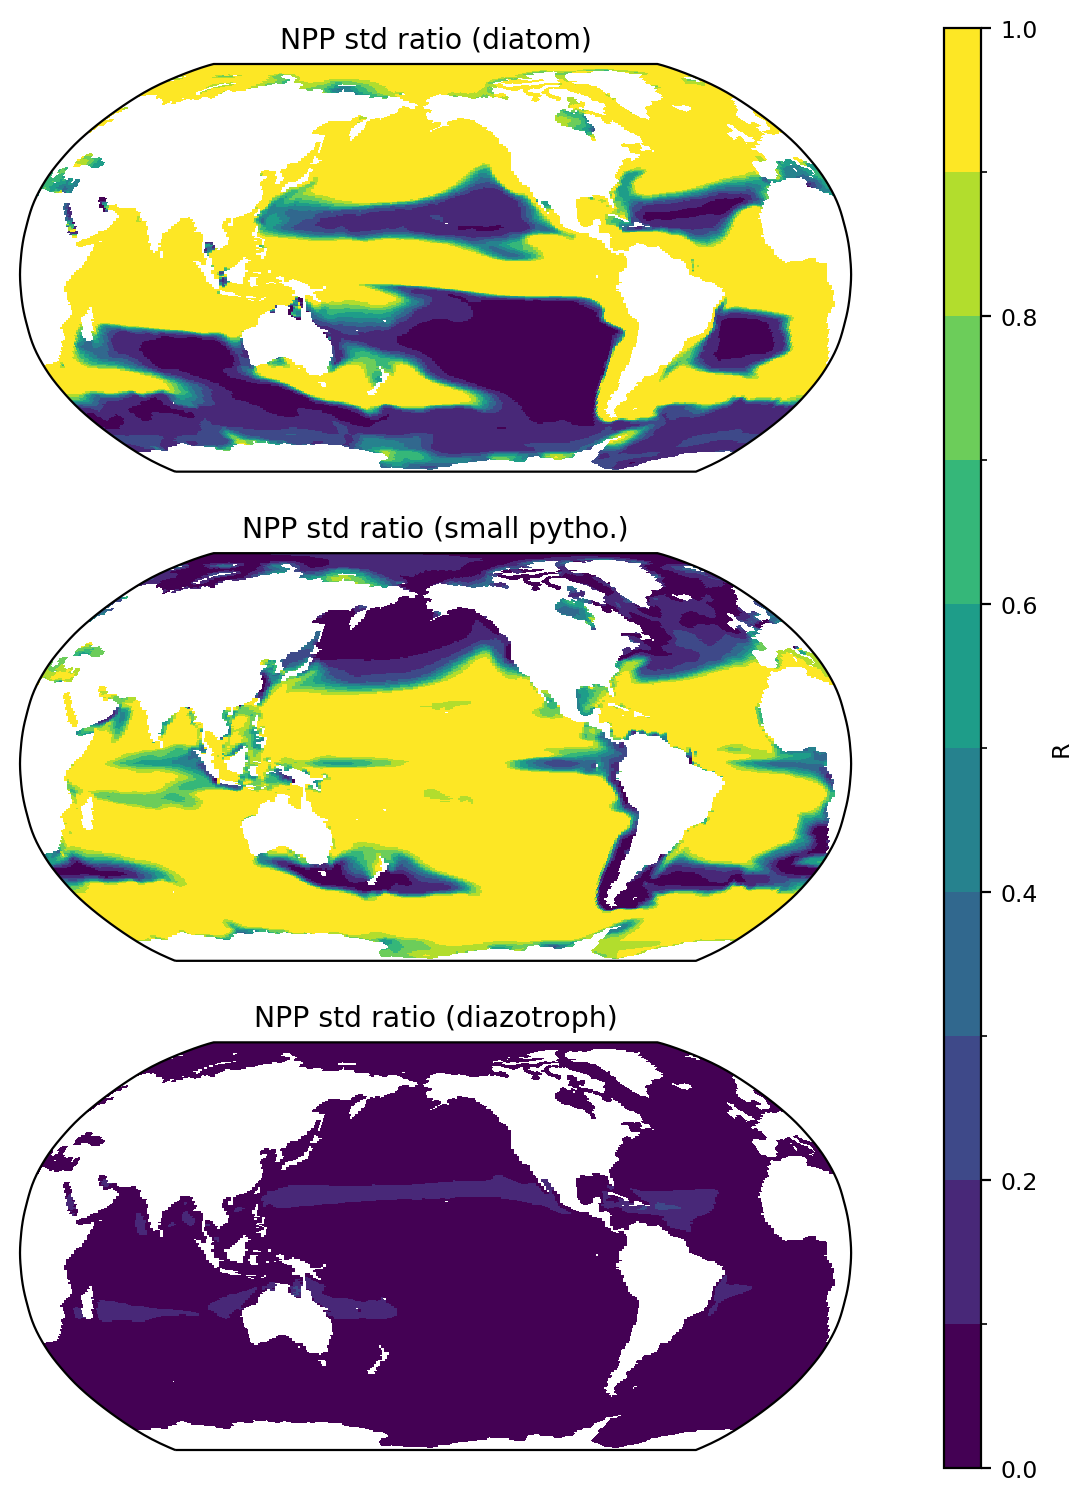

elasped time for calculating correlation: 11.041339635848999


In [72]:
# plot for NPP_ratio

start_time = time.time()

varn=cfg_var_NPP_TOT.var #example

if cfg_var_NPP_TOT.comp=='ocn':
    ds_grid = pop_tools.get_grid('POP_gx1v7')

data_array=timstd_NPP_diat['ratio']
data_array.attrs['name'] = cfg_var_NPP_TOT.var
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT

cmap = plt.cm.viridis  
levels = np.linspace(0, 1, 11)  
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N, clip=True)
projection = ccrs.Robinson(central_longitude=200)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(18.5, 9), 
             dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection}, constrained_layout=False)


# fig1: diat
plt1=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[0], 
                        transform=ccrs.PlateCarree(), vmax=1, vmin=0,cmap=cmap, norm=norm, add_colorbar=False)

axes[0].set_title('NPP std ratio (diatom)')
# axes[0].gridlines(draw_labels=True) 
# axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}°'))
# axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}°'))


# fig2: sp
data_array=timstd_NPP_sp['ratio']
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT

plt2=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[1], 
                        transform=ccrs.PlateCarree(), vmax=1, vmin=0,cmap=cmap, norm=norm, add_colorbar=False)
axes[1].set_title('NPP std ratio (small pytho.)')

# fig2: diaz
data_array=timstd_NPP_diaz['ratio']
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT

plt3=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[2], 
                        transform=ccrs.PlateCarree(), vmax=1, vmin=0,cmap=cmap, norm=norm, add_colorbar=False)
axes[2].set_title('NPP std ratio (diazotroph)')

plt.rcParams.update({'font.size': 8.5})

cbar_a_c = fig.add_axes([0.65, 0.1, 0.01, 0.8])  # [left, bottom, width, height] 비율로 컬러바 위치와 크기 설정
cbar1 = fig.colorbar(plt1, cax=cbar_a_c, orientation='vertical')
cbar1.set_label('R')

plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for calculating correlation: ' + str(elapsed_time))